# Load libraries and data

In [1]:
import os
os.environ['R_HOME'] = "/usr/lib/R/"
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import scFates as scf
import pandas as pd
import numpy as np
sc.set_figure_params(figsize=(5,5),dpi_save=600)
emb_back=pd.read_csv("_Output/tsne_pal-6.csv",index_col=0).values

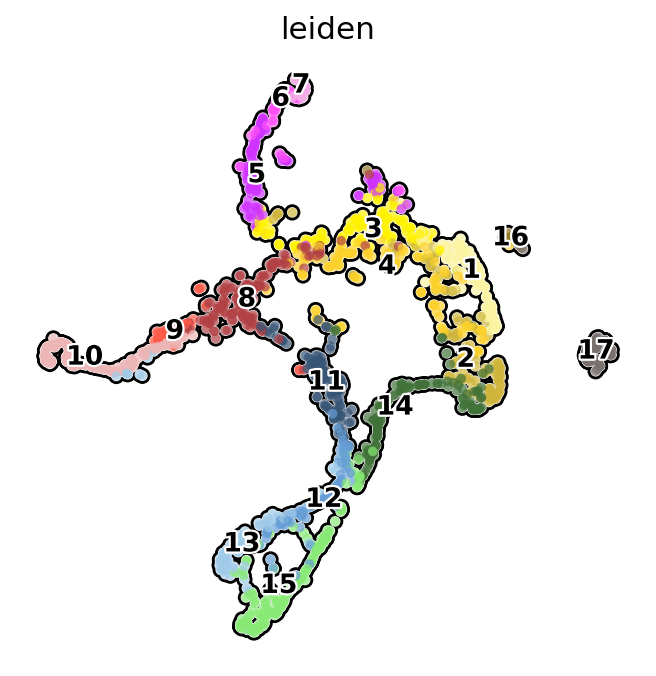

In [2]:
adata=sc.read("_Output/adata_SGN.h5ad")

sc.pl.tsne(adata,color="leiden",legend_loc="on data",add_outline=True,legend_fontsize=12, legend_fontoutline=2,frameon=False)
emb_back=adata.obsm["X_tsne"].copy()

## Load SCENIC data

In [3]:
auc=pd.read_csv("_SCENIC/output/auc_mtx_mm10.csv",index_col=0)

In [4]:
adata=adata[adata.obs.leiden.isin([1,2,3,4])]

# Early cells

inferring a principal tree --> parameters used 
    250 principal points, sigma = 0.1, lambda = 2000
    :   8%|▊         | 4/50 [00:00<00:06,  6.70it/s]
    converged


Trying to set attribute `.uns` of view, copying.


    finished (0:00:01) --> added 
    'ppt', dictionnary containing inferred tree (adata.uns)
    'tree/B', adjacency matrix of the principal points (adata.uns)
    'tree/R', soft assignment of cells to principal point in representation space (adata.uns)
    'tree/F', coordinates of principal points in representation space (adata.uns)


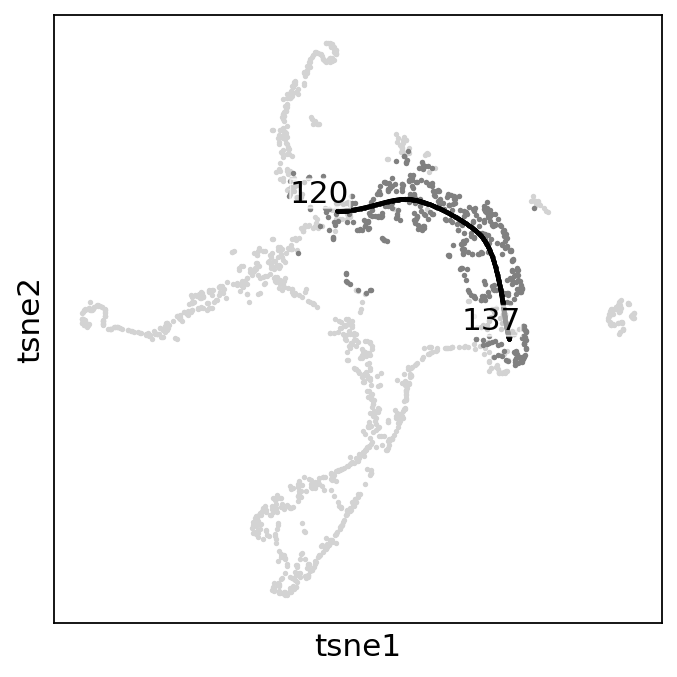

In [5]:
scf.tl.tree(adata,use_rep="diffusion",Nodes=250,method="ppt",ppt_lambda=2000,seed=1)
scf.pl.tree(adata,basis="tsne",emb_back=emb_back,size_nodes=1)

## Test and fit associated regulons

root selected --> added
    'tree/root', selected root (adata.uns)
    'tree/pp_info', for each PP, its distance vs root and segment assignment (adata.uns)
    'tree/pp_seg', segments network information (adata.uns)
projecting cells onto the principal tree
    finished (0:00:01) --> added
    'edge', assigned edge (adata.obs)
    't', pseudotime value (adata.obs)
    'seg', segment of the tree where the cell is assigned to (adata.obs)
    'milestones', milestones assigned to (adata.obs)
    'pseudotime_list', list of cell projection from all mappings (adata.uns)
test features for association with the tree
    mapping 0: 100%|██████████| 61/61 [00:11<00:00,  5.11it/s]
    found 15 significant features (0:00:12) --> added
    'p_val' values from statistical test (adata.var)
    'fdr' corrected values from multiple testing (adata.var)
    'st' proportion of mapping in which feature is significant (adata.var)
    'A' amplitue of change of tested feature (adata.var)
    'signi' feature is s

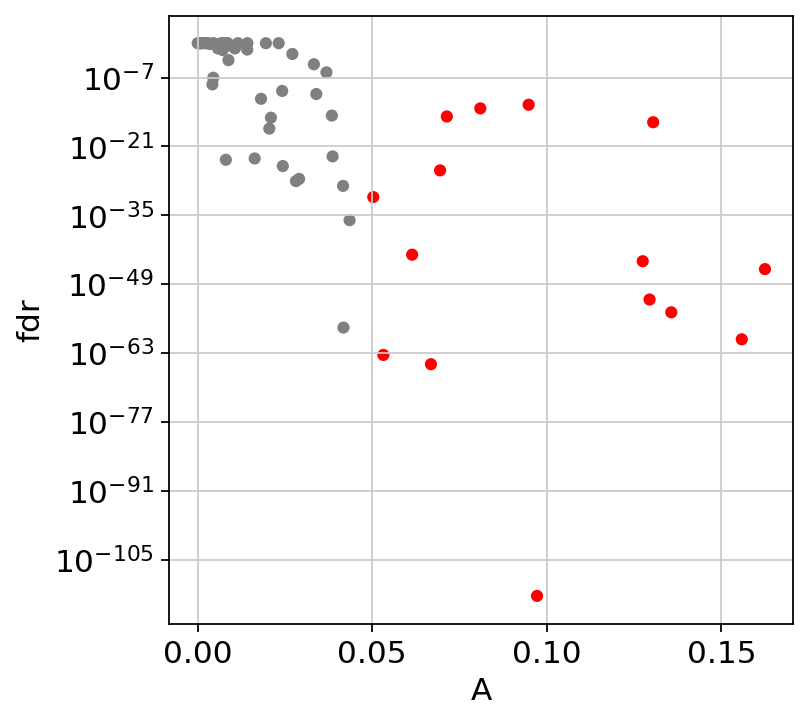

In [6]:
import anndata
adata=anndata.AnnData(auc.loc[adata.obs_names,:],obs=adata.obs,obsm=adata.obsm,uns=adata.uns)
scf.tl.root(adata,137)
scf.tl.pseudotime(adata)
scf.tl.test_association(adata,n_jobs=20,A_cut=0.05)
scf.pl.test_association(adata)
scf.tl.fit(adata)

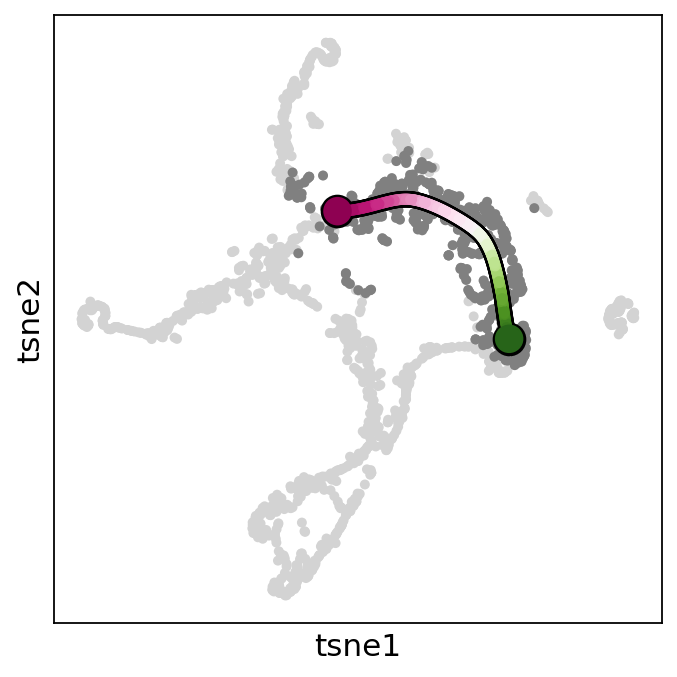

In [7]:
scf.pl.trajectory(adata,basis="tsne",colormap="PiYG_r",emb_back=emb_back,size_cells=20)

found 1 complex fitted features
--> added
    'complex' column in (adata.var)


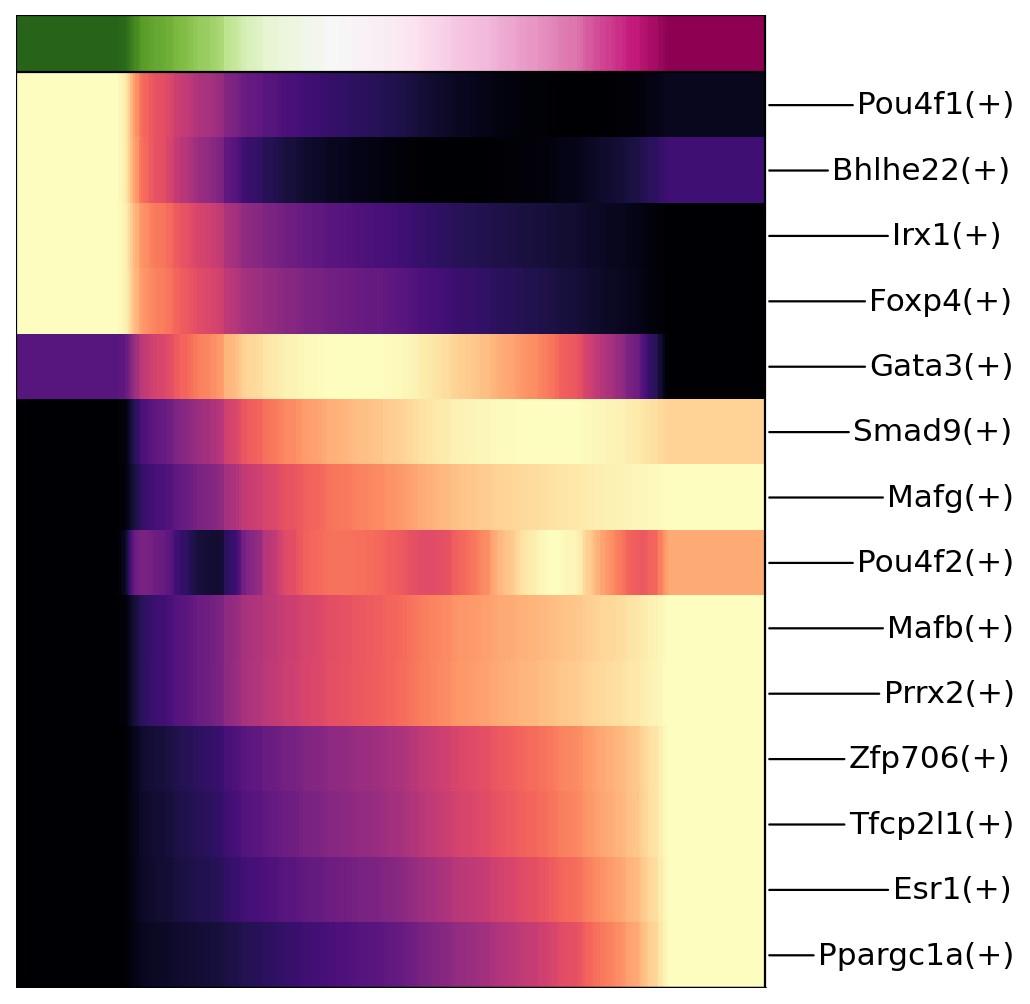

In [8]:
scf.pl.trends(adata,basis="tsne",n_features=15,show_milsetones=False,colormap="magma",pseudo_colormap="PiYG_r",
                     emb_back=emb_back,save="_early_auc.png")

In [9]:
fpm=pd.read_csv("_Output/fpm.csv",index_col=0)
fpm=fpm.loc[:,adata.obs_names]

In [10]:
gata3=adata[:,"Gata3(+)"].X.flatten()

In [11]:
from scipy.stats import pearsonr

In [12]:
corrs=fpm.apply(lambda x: pearsonr(x,gata3)[0],axis=1)
corrs=corrs.sort_values(ascending=False)
corrs.dropna(inplace=True)

In [14]:
corrs.to_csv("supp_Fig2c.csv")

## Focus on Gata3 regulon

### Gene expression correlations

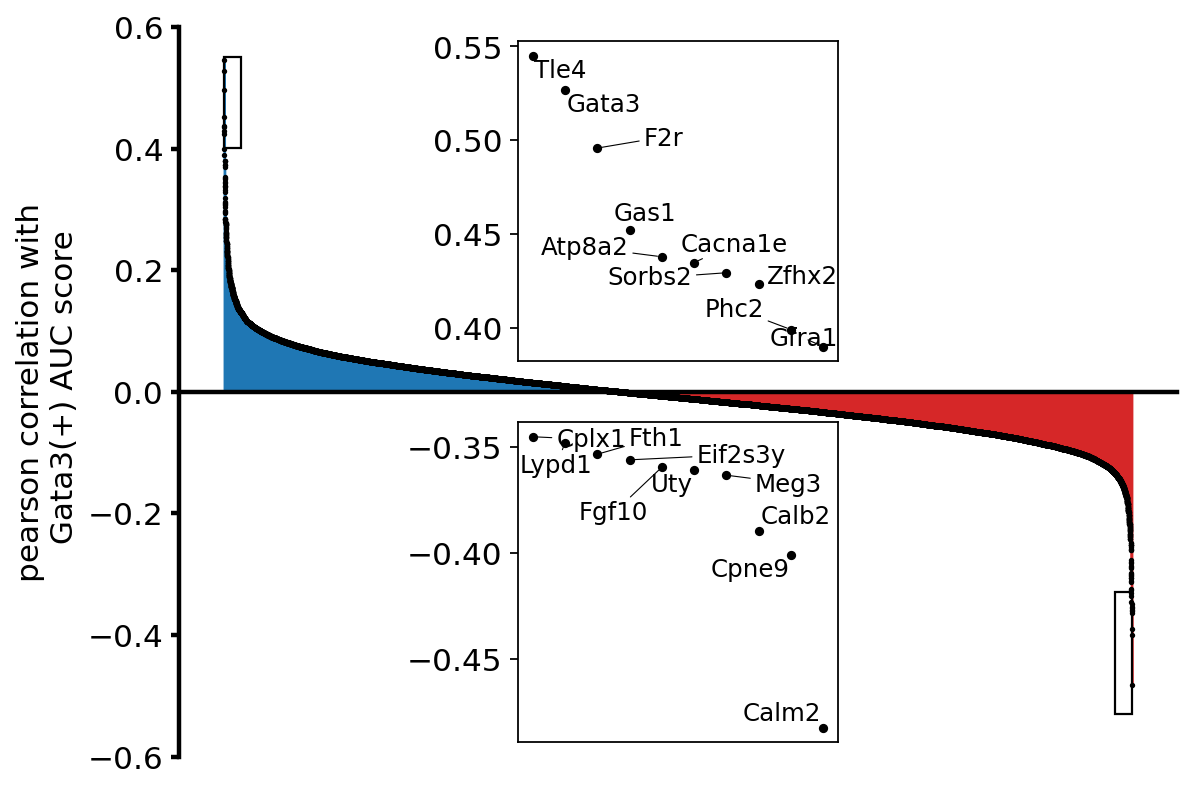

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib import patches
from adjustText import adjust_text
fig, ax = plt.subplots(figsize=(8,6))

ax.fill_between(range(len(corrs)), 0, corrs, where=corrs >= 0,color="tab:blue")
ax.fill_between(range(len(corrs)), 0, corrs, where=corrs <= 0,color="tab:red")
ax.scatter(range(len(corrs)),corrs,c="k",s=2)
ax.grid(b=False)
ax.set_ylim([-0.6,0.6])
ax.spines['left'].set_position(('axes', 0))
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position(('axes', 0.5))
ax.spines['top'].set_color('none')
ax.set_xticks([])
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_ylabel("pearson correlation with\n Gata3(+) AUC score")
ax.yaxis.set_tick_params(width=2)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)


patch = patches.Rectangle((0, 0.4), 500, 0.15, fill=False, alpha=1) # We add a rectangle to make sure the labels don't move to the right
ax.add_patch(patch)

patch = patches.Rectangle((len(corrs)-500, -0.33), 500, -0.2, fill=False, alpha=1) # We add a rectangle to make sure the labels don't move to the right
ax.add_patch(patch)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax2 = inset_axes(ax,
                    width=2, # width = 30% of parent_bbox
                    height=2., # height : 1 inch
                    loc="upper center")
xs=range(1,11)
ys=corrs[:10]
ls=corrs[:10].index

ax2.scatter(xs,ys,c="k",s=10)
ax2.grid(b=False)
ax2.set_xticks([])
texts = []
for x, y, l in zip(xs, ys,ls):
    texts.append(ax2.text(x, y, l, size=11))

adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

ax3 = inset_axes(ax,
                    width=2, # width = 30% of parent_bbox
                    height=2., # height : 1 inch
                    loc="lower center")
xs=range(1,11)
ys=corrs[-10:]
ls=corrs[-10:].index

ax3.scatter(xs,ys,c="k",s=10)
ax3.grid(b=False)
ax3.set_xticks([])
texts = []
for x, y, l in zip(xs, ys,ls):
    texts.append(ax3.text(x, y, l, size=11))

adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5), expand_text=(1.05, 1.05))

plt.savefig("figures/Gata3_corr.png")

### Root selection

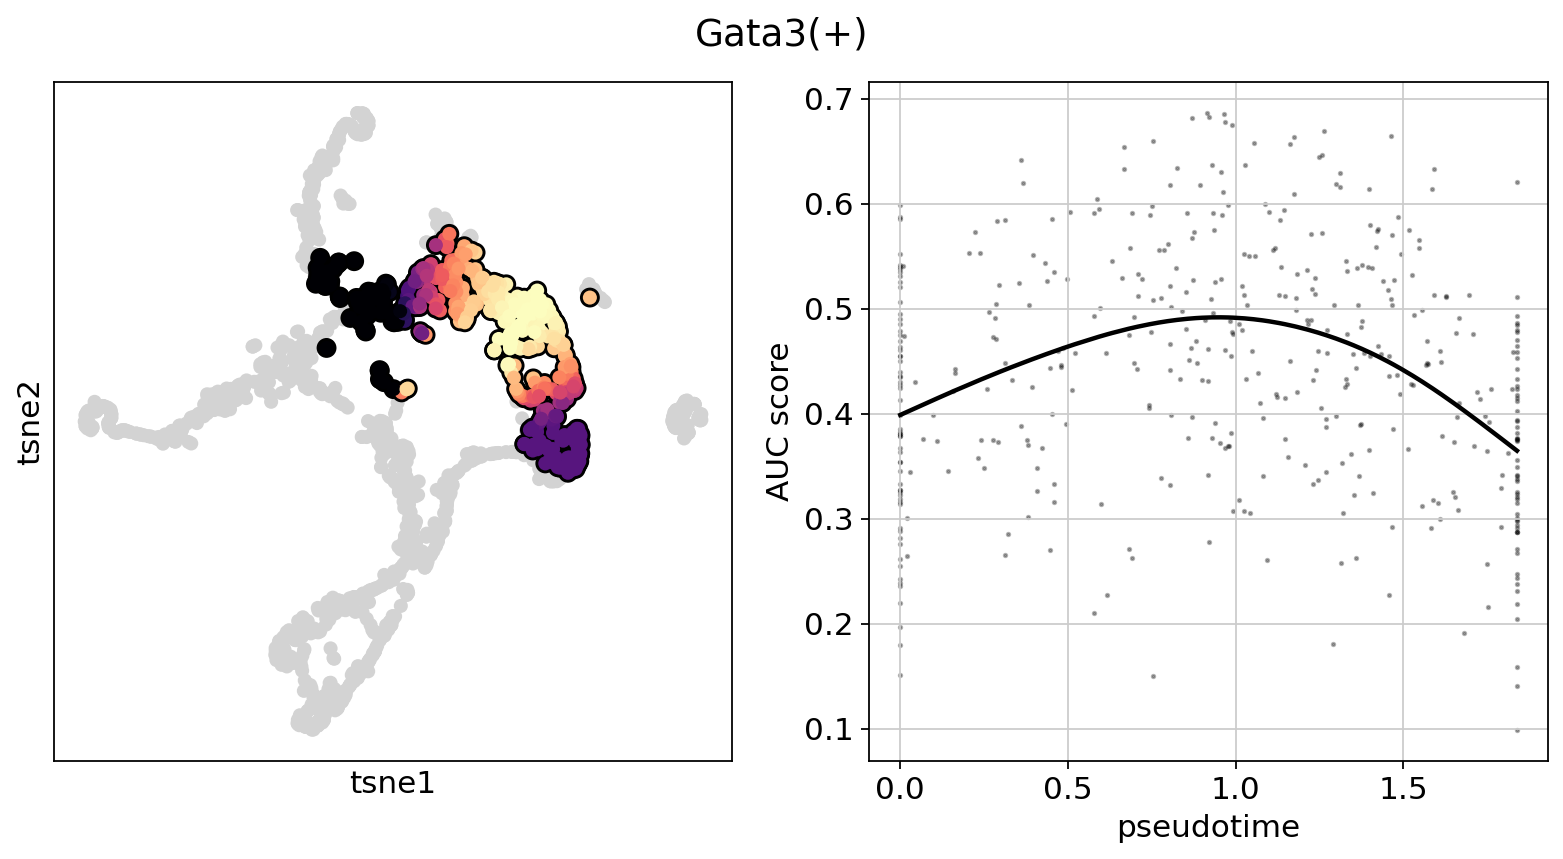

In [16]:
scf.pl.single_trend(adata,feature="Gata3(+)",
                    basis="tsne",emb_back=emb_back,
                    ylab="AUC score",colormap="magma",
                    size_cells=40,highlight=True,colorexp="k",save="_early_Gata3.png")

In [25]:
root_node=(adata.uns["tree"]["pp_info"].time-adata.obs.iloc[np.argmax(adata[:,"Gata3(+)"].layers["fitted"]),2]).abs().idxmin()

In [26]:
scf.tl.root(adata,root_node)

root selected --> added
    'tree/root', selected root (adata.uns)
    'tree/pp_info', for each PP, its distance vs root and segment assignment (adata.uns)
    'tree/pp_seg', segments network information (adata.uns)


In [27]:
adata.uns["tree"]["pp_seg"]

,n,from,to,d
1,1,174,120,0.882552
2,2,174,137,0.956082


In [28]:
scf.tl.pseudotime(adata)

projecting cells onto the principal tree
    finished (0:00:01) --> added
    'edge', assigned edge (adata.obs)
    't', pseudotime value (adata.obs)
    'seg', segment of the tree where the cell is assigned to (adata.obs)
    'milestones', milestones assigned to (adata.obs)
    'tree/pseudotime_list', list of cell projection from all mappings (adata.uns)


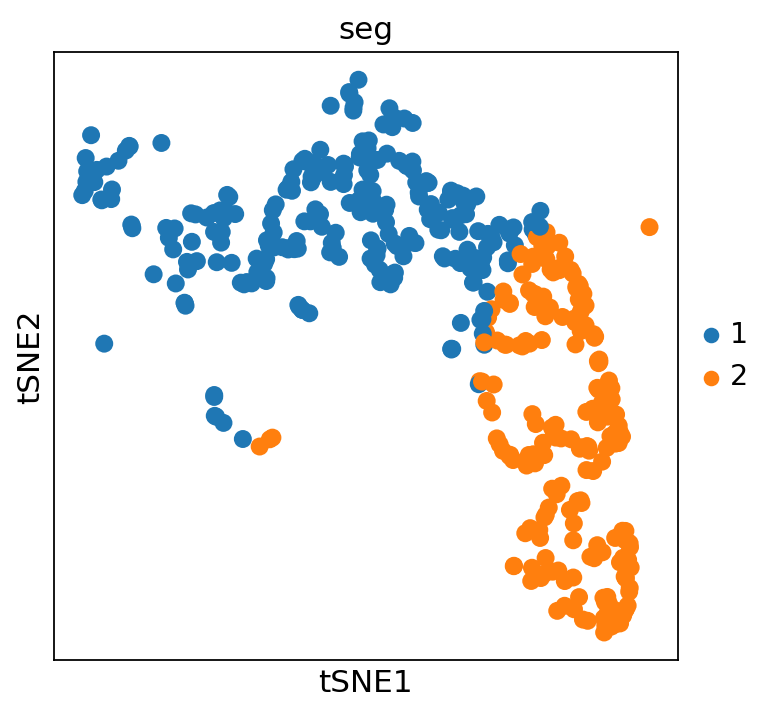

In [29]:
sc.pl.tsne(adata,color="seg")

In [30]:
adata.write_h5ad("_Output/adata_early.h5ad")

In [31]:
adata=sc.read("_Output/adata_early.h5ad")
cells_pou4f1=adata[adata.obs.seg=="2"].obs_names
cells_rest=adata[adata.obs.seg=="1"].obs_names

# Type Ic

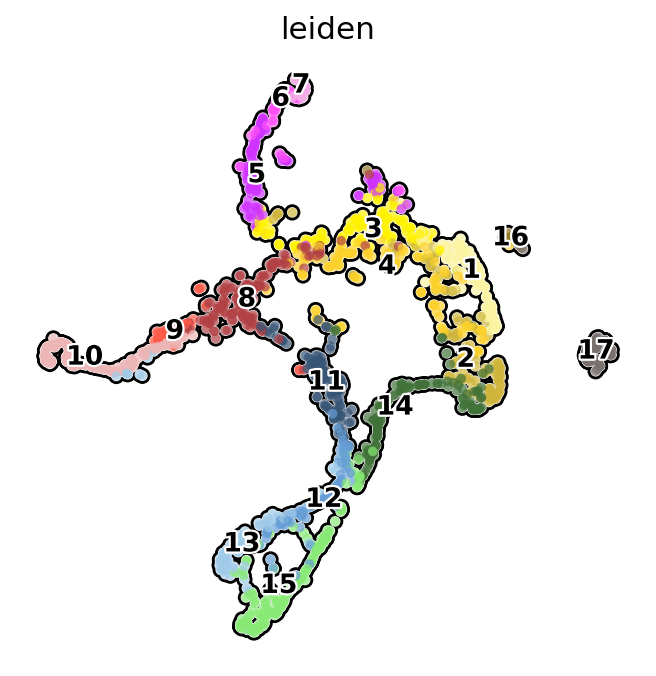

In [33]:
adata=sc.read("_Output/adata_SGN.h5ad")

sc.pl.tsne(adata,color="leiden",legend_loc="on data",add_outline=True,legend_fontsize=12, legend_fontoutline=2,frameon=False)
emb_back=adata.obsm["X_tsne"].copy()

In [35]:
adata=adata[(adata.obs.leiden.isin([14,15]) | adata.obs_names.isin(cells_pou4f1))]

inferring a principal tree --> parameters used 
    200 principal points, sigma = 0.2, lambda = 100
    :  44%|████▍     | 22/50 [00:02<00:02,  9.51it/s]

Trying to set attribute `.uns` of view, copying.



    converged
    finished (0:00:12) --> added 
    'ppt', dictionnary containing inferred tree (adata.uns)
    'tree/B', adjacency matrix of the principal points (adata.uns)
    'tree/R', soft assignment of cells to principal point in representation space (adata.uns)
    'tree/F', coordinates of principal points in representation space (adata.uns)


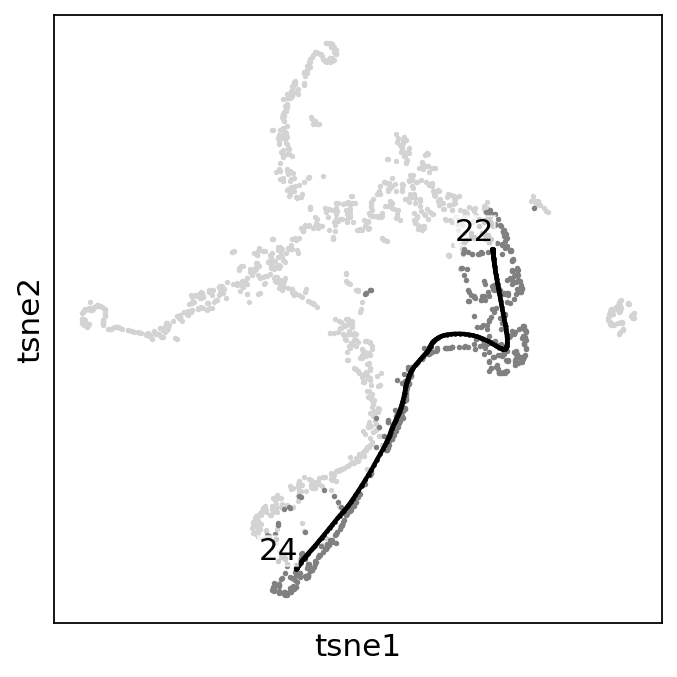

In [36]:
scf.tl.tree(adata,use_rep="diffusion",Nodes=200,method="ppt",ppt_sigma=.2,ppt_lambda=100,seed=1)
scf.pl.tree(adata,basis="tsne",emb_back=emb_back,size_nodes=1)

In [37]:
scf.tl.root(adata,22)
scf.tl.pseudotime(adata)

root selected --> added
    'tree/root', selected root (adata.uns)
    'tree/pp_info', for each PP, its distance vs root and segment assignment (adata.uns)
    'tree/pp_seg', segments network information (adata.uns)
projecting cells onto the principal tree
    finished (0:00:00) --> added
    'edge', assigned edge (adata.obs)
    't', pseudotime value (adata.obs)
    'seg', segment of the tree where the cell is assigned to (adata.obs)
    'milestones', milestones assigned to (adata.obs)
    'tree/pseudotime_list', list of cell projection from all mappings (adata.uns)


In [38]:
scf.tl.test_association(adata,layer="fpm",n_jobs=20)

test features for association with the tree
    mapping 0: 100%|██████████| 27210/27210 [01:19<00:00, 341.84it/s]
    found 591 significant features (0:01:20) --> added
    'p_val' values from statistical test (adata.var)
    'fdr' corrected values from multiple testing (adata.var)
    'st' proportion of mapping in which feature is significant (adata.var)
    'A' amplitue of change of tested feature (adata.var)
    'tree/stat_assoc_list', list of fitted features on the tree for all mappings (adata.uns)


reapplied filters, 3157 significant features


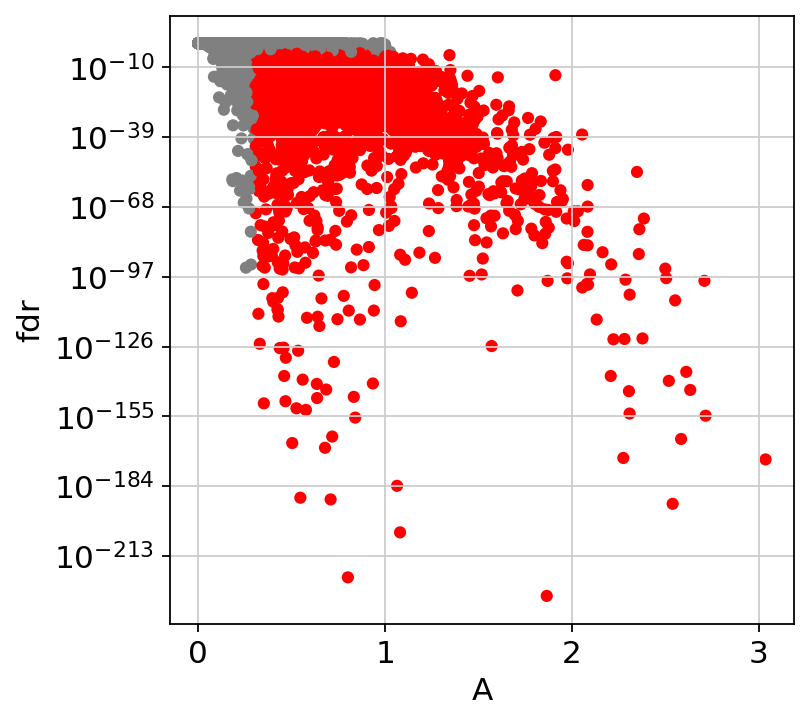

In [39]:
scf.tl.test_association(adata,reapply_filters=True,A_cut=0.3)
scf.pl.test_association(adata)

In [40]:
scf.tl.fit(adata,layer="fpm",n_jobs=20)

fit features associated with the tree
    mapping 0: 100%|██████████| 3157/3157 [00:14<00:00, 224.32it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:22) --> added
    'fitted', fitted features on the tree for all mappings (adata.layers)


In [41]:
adata.write_h5ad("_Output/adata_Ic_tree.h5ad")

# Type II

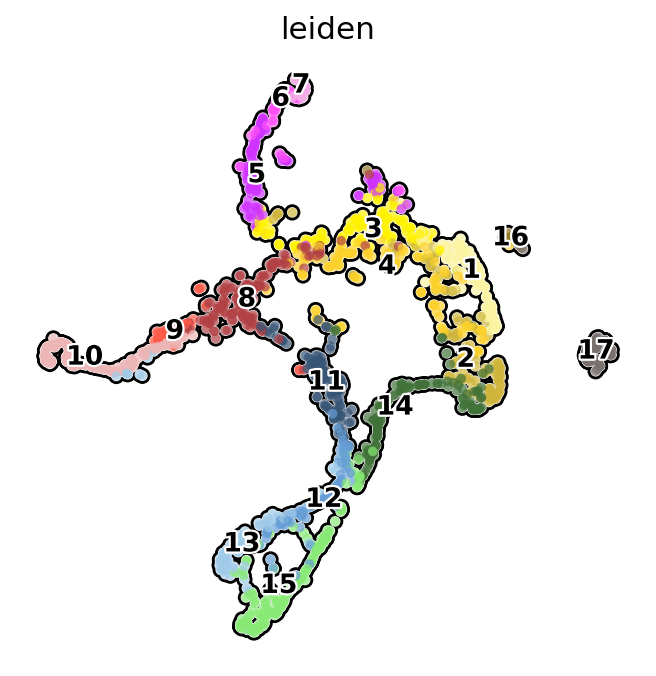

In [42]:
adata=sc.read("_Output/adata_SGN.h5ad")

sc.pl.tsne(adata,color="leiden",legend_loc="on data",add_outline=True,legend_fontsize=12, legend_fontoutline=2,frameon=False)
emb_back=adata.obsm["X_tsne"].copy()

In [43]:
adata=adata[(adata.obs.leiden.isin([5,6,7]) | adata.obs_names.isin(cells_rest))]

inferring a principal tree --> parameters used 
    200 principal points, sigma = 0.2, lambda = 100
    :  20%|██        | 10/50 [00:01<00:05,  7.31it/s]
    converged


Trying to set attribute `.uns` of view, copying.


    finished (0:00:10) --> added 
    'ppt', dictionnary containing inferred tree (adata.uns)
    'tree/B', adjacency matrix of the principal points (adata.uns)
    'tree/R', soft assignment of cells to principal point in representation space (adata.uns)
    'tree/F', coordinates of principal points in representation space (adata.uns)


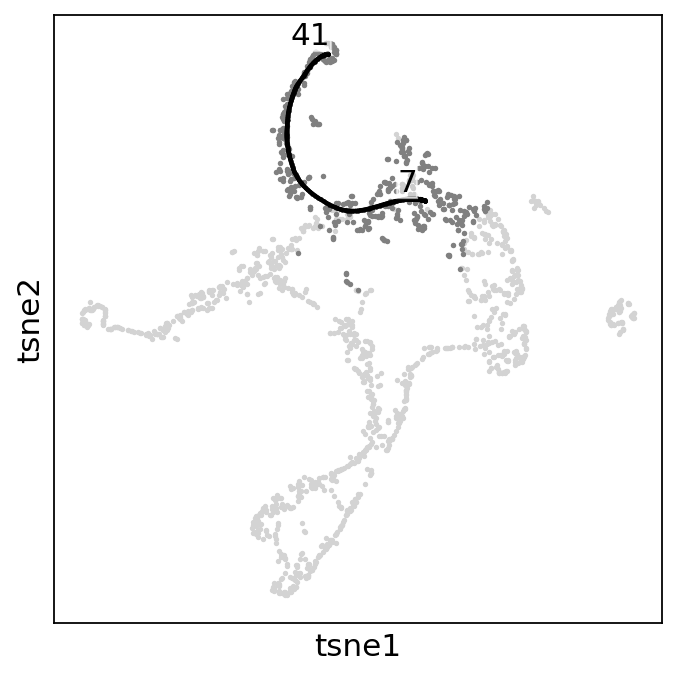

In [44]:
scf.tl.tree(adata,use_rep="diffusion",Nodes=200,method="ppt",ppt_sigma=.2,ppt_lambda=100,seed=1)
scf.pl.tree(adata,basis="tsne",emb_back=emb_back,size_nodes=1)

In [45]:
scf.tl.root(adata,7)
scf.tl.pseudotime(adata)
scf.tl.test_association(adata,n_jobs=20,layer="fpm")

root selected --> added
    'tree/root', selected root (adata.uns)
    'tree/pp_info', for each PP, its distance vs root and segment assignment (adata.uns)
    'tree/pp_seg', segments network information (adata.uns)
projecting cells onto the principal tree
    finished (0:00:01) --> added
    'edge', assigned edge (adata.obs)
    't', pseudotime value (adata.obs)
    'seg', segment of the tree where the cell is assigned to (adata.obs)
    'milestones', milestones assigned to (adata.obs)
    'tree/pseudotime_list', list of cell projection from all mappings (adata.uns)
test features for association with the tree
    mapping 0: 100%|██████████| 27210/27210 [01:05<00:00, 416.17it/s]
    found 180 significant features (0:01:05) --> added
    'p_val' values from statistical test (adata.var)
    'fdr' corrected values from multiple testing (adata.var)
    'st' proportion of mapping in which feature is significant (adata.var)
    'A' amplitue of change of tested feature (adata.var)
    'tree/s

reapplied filters, 577 significant features


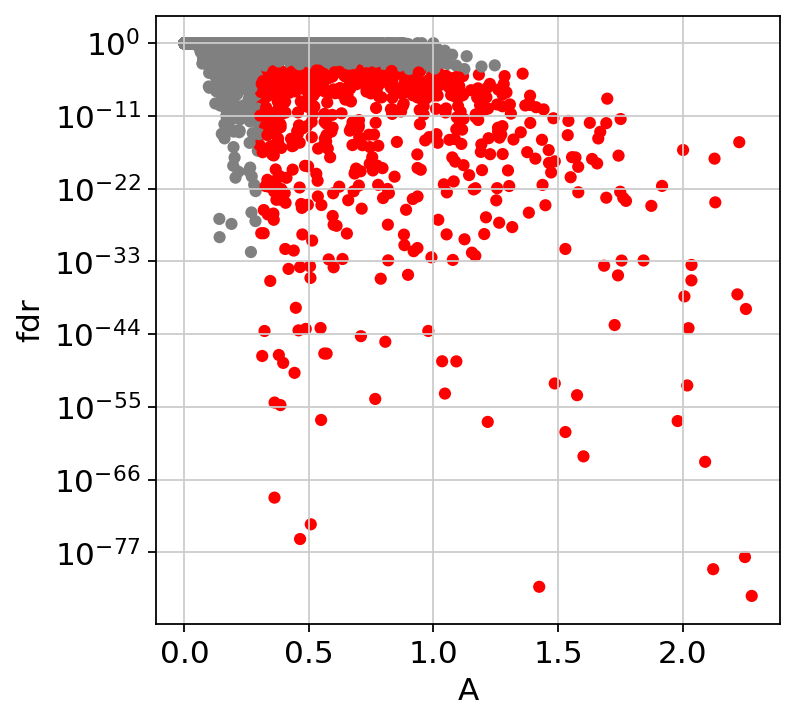

In [46]:
scf.tl.test_association(adata,reapply_filters=True,A_cut=0.3)
scf.pl.test_association(adata)

In [47]:
scf.tl.fit(adata,layer="fpm",n_jobs=20)

fit features associated with the tree
    mapping 0: 100%|██████████| 577/577 [00:01<00:00, 303.58it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:06) --> added
    'fitted', fitted features on the tree for all mappings (adata.layers)


In [49]:
adata.write_h5ad("_Output/adata_II_tree.h5ad")

# Type Ia

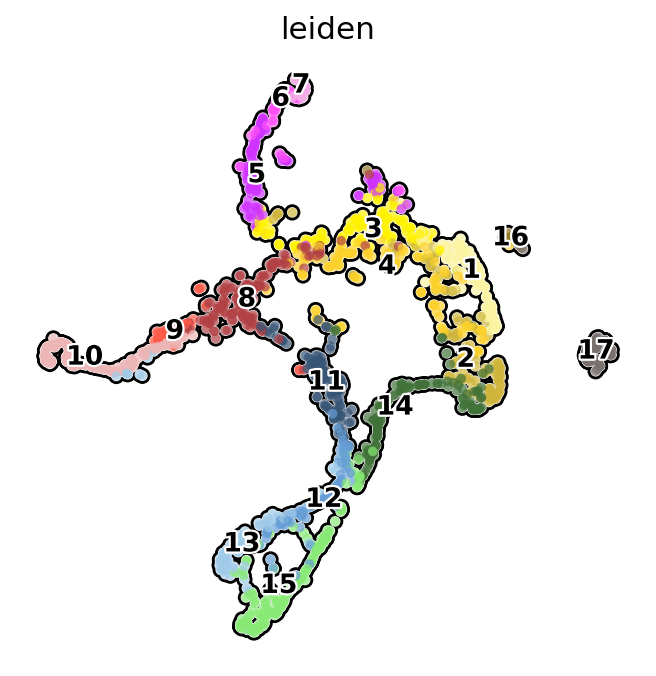

In [50]:
adata=sc.read("_Output/adata_SGN.h5ad")

sc.pl.tsne(adata,color="leiden",legend_loc="on data",add_outline=True,legend_fontsize=12, legend_fontoutline=2,frameon=False)
emb_back=adata.obsm["X_tsne"].copy()

In [52]:
adata=adata[(adata.obs.leiden.isin([8,9,10]) | adata.obs_names.isin(cells_rest))]

inferring a principal tree --> parameters used 
    200 principal points, sigma = 0.2, lambda = 100
    : 100%|██████████| 50/50 [00:04<00:00, 11.57it/s]

Trying to set attribute `.uns` of view, copying.



    not converged (error: 0.005281063390589503)
    finished (0:00:06) --> added 
    'ppt', dictionnary containing inferred tree (adata.uns)
    'tree/B', adjacency matrix of the principal points (adata.uns)
    'tree/R', soft assignment of cells to principal point in representation space (adata.uns)
    'tree/F', coordinates of principal points in representation space (adata.uns)


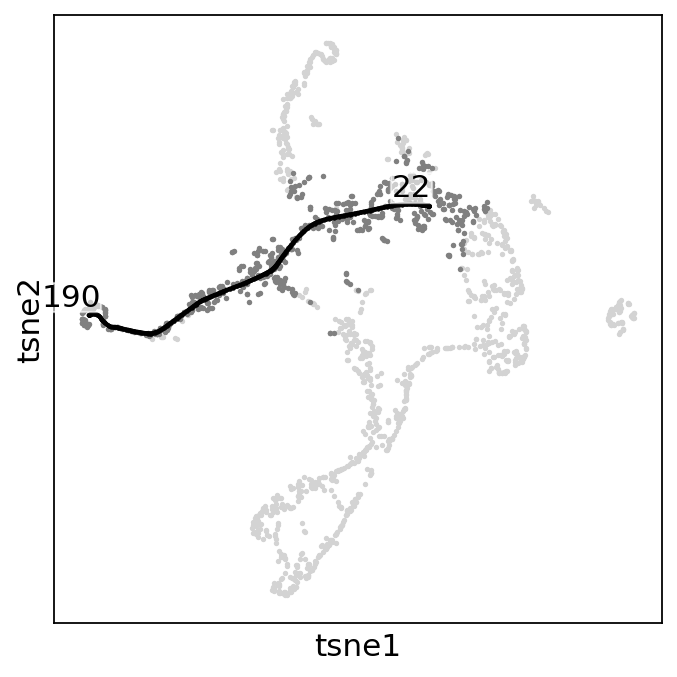

In [53]:
scf.tl.tree(adata,use_rep="diffusion",Nodes=200,method="ppt",ppt_sigma=.2,ppt_lambda=100,seed=1)
scf.pl.tree(adata,basis="tsne",emb_back=emb_back,size_nodes=1)

In [54]:
scf.tl.root(adata,22)
scf.tl.pseudotime(adata)
scf.tl.test_association(adata,n_jobs=20,layer="fpm")

root selected --> added
    'tree/root', selected root (adata.uns)
    'tree/pp_info', for each PP, its distance vs root and segment assignment (adata.uns)
    'tree/pp_seg', segments network information (adata.uns)
projecting cells onto the principal tree
    finished (0:00:01) --> added
    'edge', assigned edge (adata.obs)
    't', pseudotime value (adata.obs)
    'seg', segment of the tree where the cell is assigned to (adata.obs)
    'milestones', milestones assigned to (adata.obs)
    'tree/pseudotime_list', list of cell projection from all mappings (adata.uns)
test features for association with the tree
    mapping 0: 100%|██████████| 27210/27210 [01:24<00:00, 323.28it/s]
    found 475 significant features (0:01:25) --> added
    'p_val' values from statistical test (adata.var)
    'fdr' corrected values from multiple testing (adata.var)
    'st' proportion of mapping in which feature is significant (adata.var)
    'A' amplitue of change of tested feature (adata.var)
    'tree/s

reapplied filters, 2583 significant features


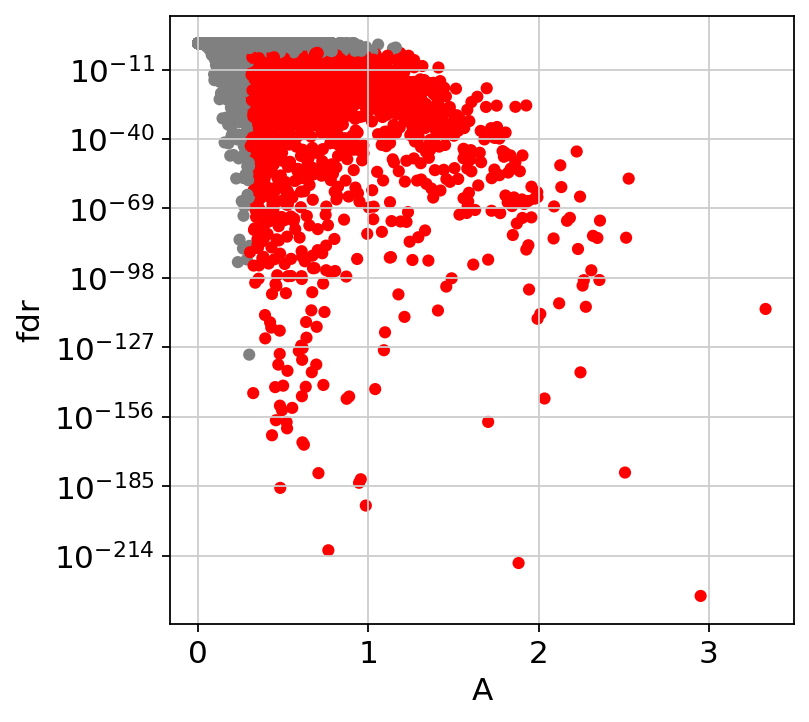

In [55]:
scf.tl.test_association(adata,reapply_filters=True,A_cut=0.3)
scf.pl.test_association(adata)

In [56]:
scf.tl.fit(adata,layer="fpm",n_jobs=20)

fit features associated with the tree
    mapping 0: 100%|██████████| 2583/2583 [00:10<00:00, 237.90it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:12) --> added
    'fitted', fitted features on the tree for all mappings (adata.layers)


In [58]:
adata.write_h5ad("_Output/adata_Ia_tree.h5ad")

# Type Ib

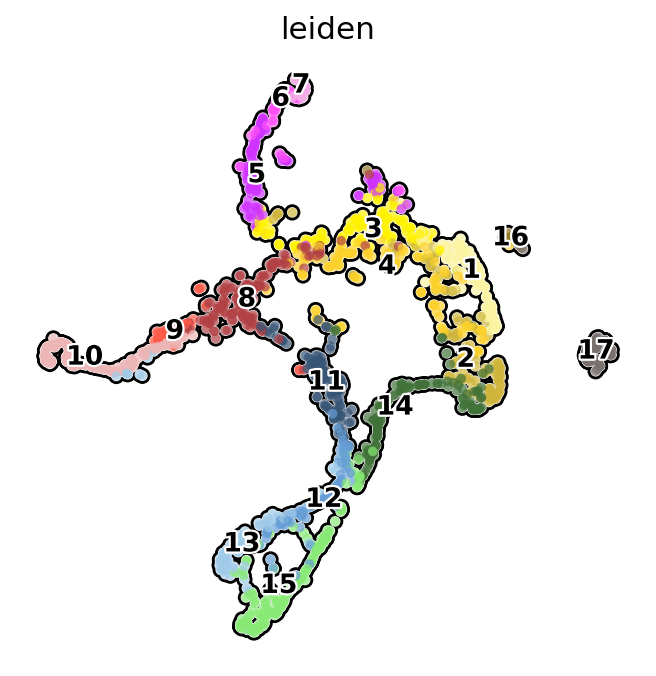

In [59]:
adata=sc.read("_Output/adata_SGN.h5ad")

sc.pl.tsne(adata,color="leiden",legend_loc="on data",add_outline=True,legend_fontsize=12, legend_fontoutline=2,frameon=False)
emb_back=adata.obsm["X_tsne"].copy()

In [60]:
adata=adata[(adata.obs.leiden.isin([11,12,13]) | adata.obs_names.isin(cells_rest))]

inferring a principal tree --> parameters used 
    200 principal points, sigma = 0.2, lambda = 300
    :  66%|██████▌   | 33/50 [00:02<00:01, 11.19it/s]

Trying to set attribute `.uns` of view, copying.



    converged
    finished (0:00:03) --> added 
    'ppt', dictionnary containing inferred tree (adata.uns)
    'tree/B', adjacency matrix of the principal points (adata.uns)
    'tree/R', soft assignment of cells to principal point in representation space (adata.uns)
    'tree/F', coordinates of principal points in representation space (adata.uns)


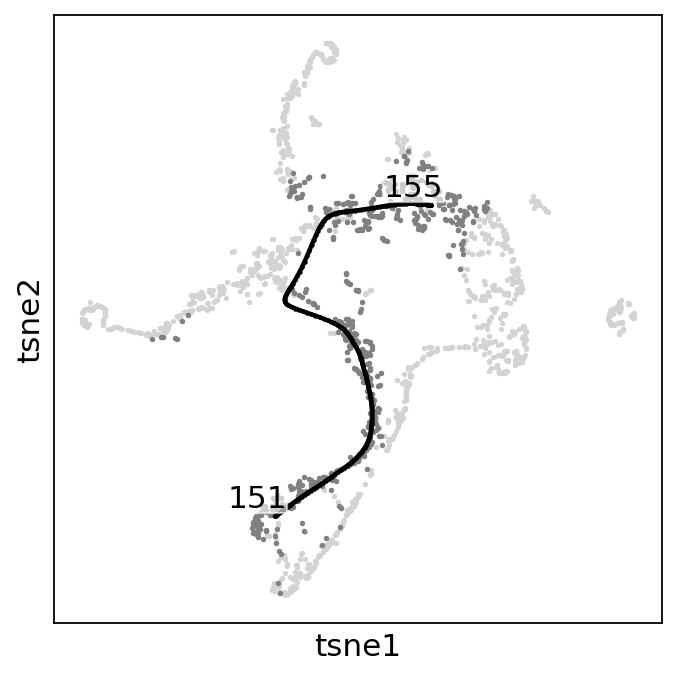

In [61]:
scf.tl.tree(adata,use_rep="diffusion",Nodes=200,method="ppt",ppt_sigma=.2,ppt_lambda=300,seed=1)
scf.pl.tree(adata,basis="tsne",emb_back=emb_back,size_nodes=1)

In [62]:
scf.tl.root(adata,155)
scf.tl.pseudotime(adata)
scf.tl.test_association(adata,n_jobs=20,layer="fpm")

root selected --> added
    'tree/root', selected root (adata.uns)
    'tree/pp_info', for each PP, its distance vs root and segment assignment (adata.uns)
    'tree/pp_seg', segments network information (adata.uns)
projecting cells onto the principal tree
    finished (0:00:01) --> added
    'edge', assigned edge (adata.obs)
    't', pseudotime value (adata.obs)
    'seg', segment of the tree where the cell is assigned to (adata.obs)
    'milestones', milestones assigned to (adata.obs)
    'tree/pseudotime_list', list of cell projection from all mappings (adata.uns)
test features for association with the tree
    mapping 0: 100%|██████████| 27210/27210 [01:16<00:00, 356.54it/s]
    found 455 significant features (0:01:16) --> added
    'p_val' values from statistical test (adata.var)
    'fdr' corrected values from multiple testing (adata.var)
    'st' proportion of mapping in which feature is significant (adata.var)
    'A' amplitue of change of tested feature (adata.var)
    'tree/s

reapplied filters, 3034 significant features


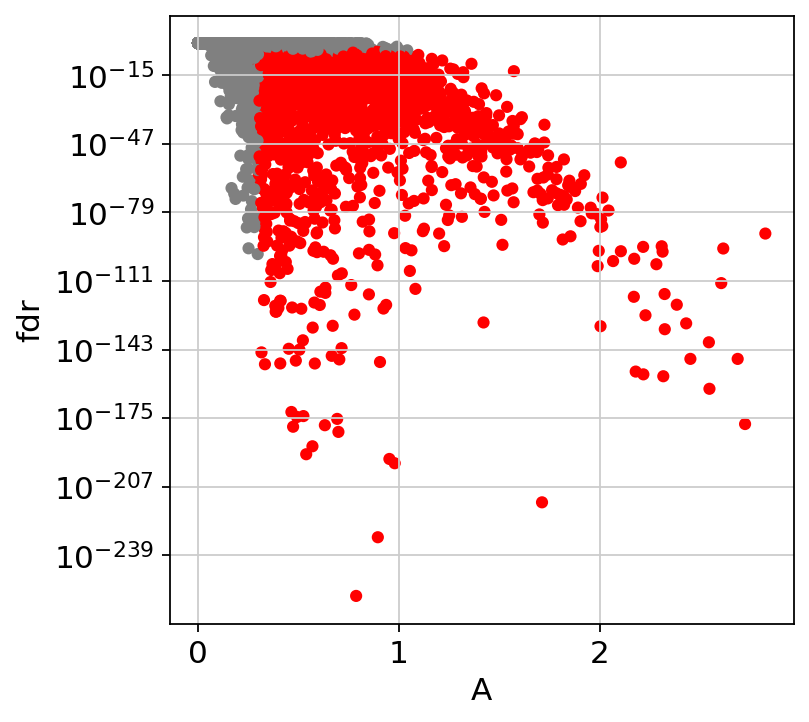

In [63]:
scf.tl.test_association(adata,reapply_filters=True,A_cut=0.3)
scf.pl.test_association(adata)

In [64]:
scf.tl.fit(adata,layer="fpm",n_jobs=20)

fit features associated with the tree
    mapping 0: 100%|██████████| 3034/3034 [00:15<00:00, 200.68it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:16) --> added
    'fitted', fitted features on the tree for all mappings (adata.layers)


In [66]:
adata.write_h5ad("_Output/adata_Ib_tree.h5ad")

# Various plots and data extraction

In [2]:
import numpy as np
import pandas as pd

adata_Ic=sc.read("_Output/adata_Ic_tree.h5ad")
adata_II=sc.read("_Output/adata_II_tree.h5ad")
adata_Ia=sc.read("_Output/adata_Ia_tree.h5ad")
adata_Ib=sc.read("_Output/adata_Ib_tree.h5ad")
allgenes=pd.Series(np.concatenate([adata_Ic.var_names,adata_II.var_names,adata_Ia.var_names,adata_Ib.var_names]))
genes=((allgenes.value_counts()==1)[allgenes.value_counts()==1]).index


Trying to set attribute `.var` of view, copying.


found 4 complex fitted features
--> added
    'complex' column in (adata.var)


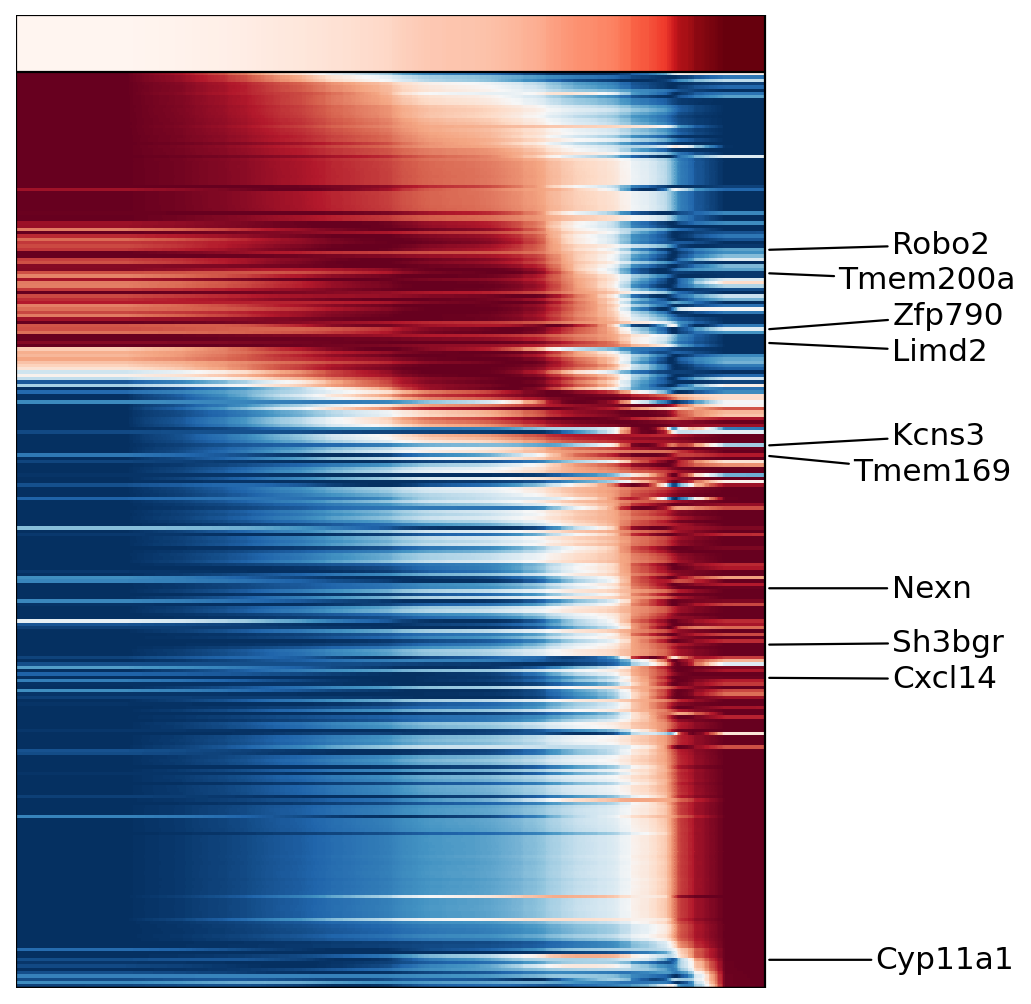

Trying to set attribute `.var` of view, copying.


found 2 complex fitted features
--> added
    'complex' column in (adata.var)


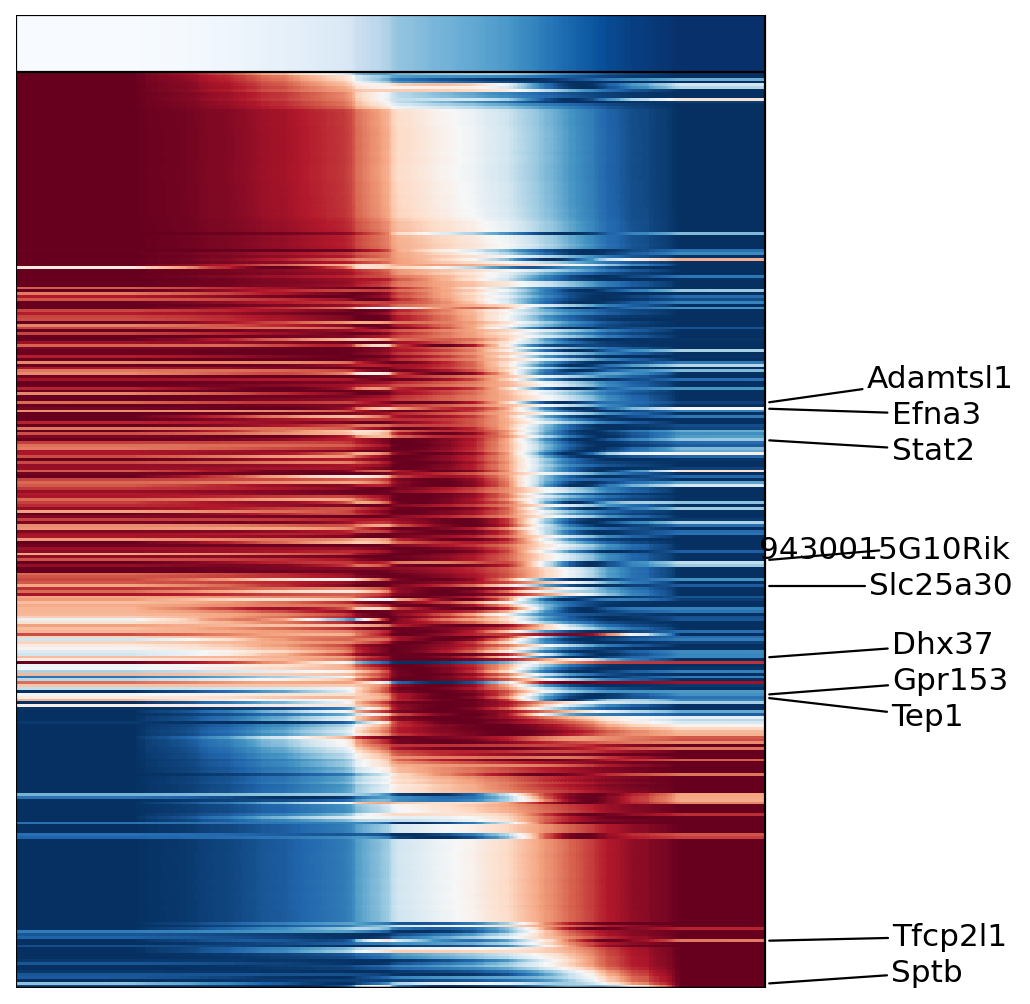

Trying to set attribute `.var` of view, copying.


found 9 complex fitted features
--> added
    'complex' column in (adata.var)


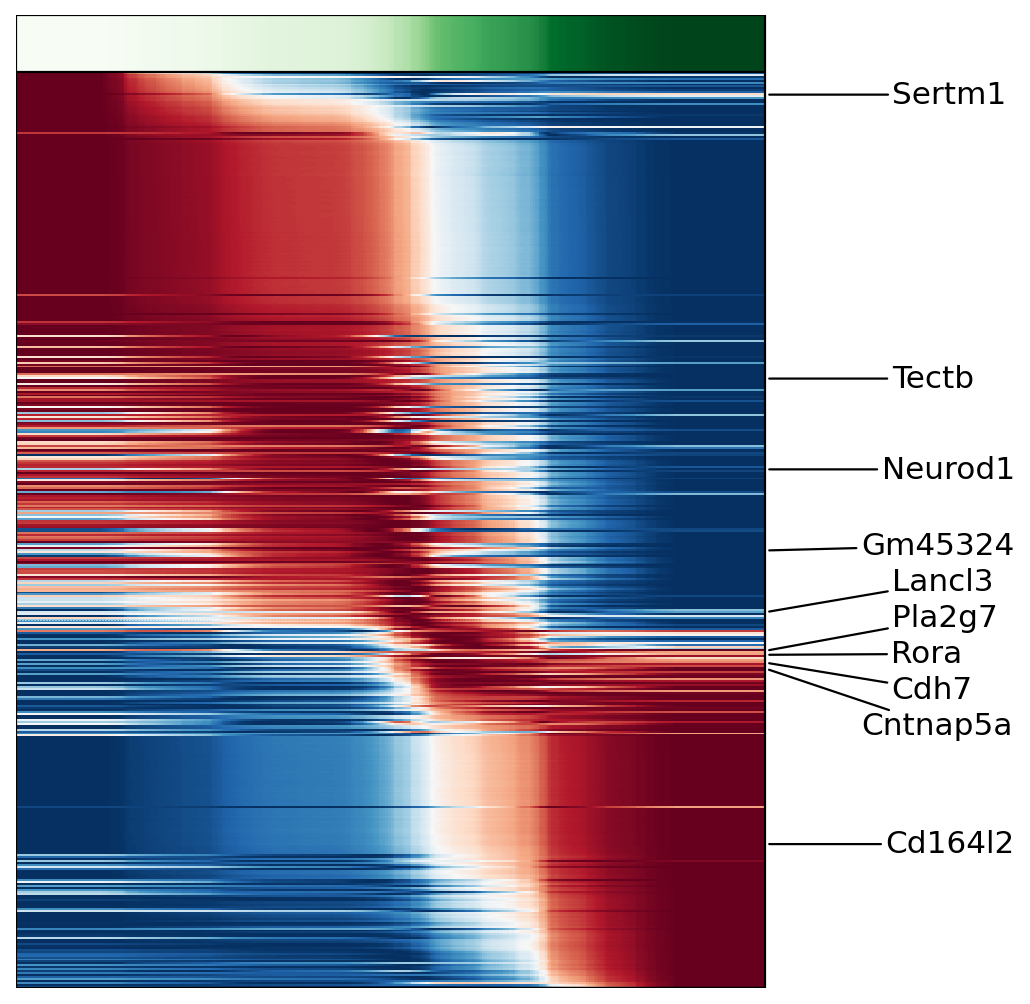

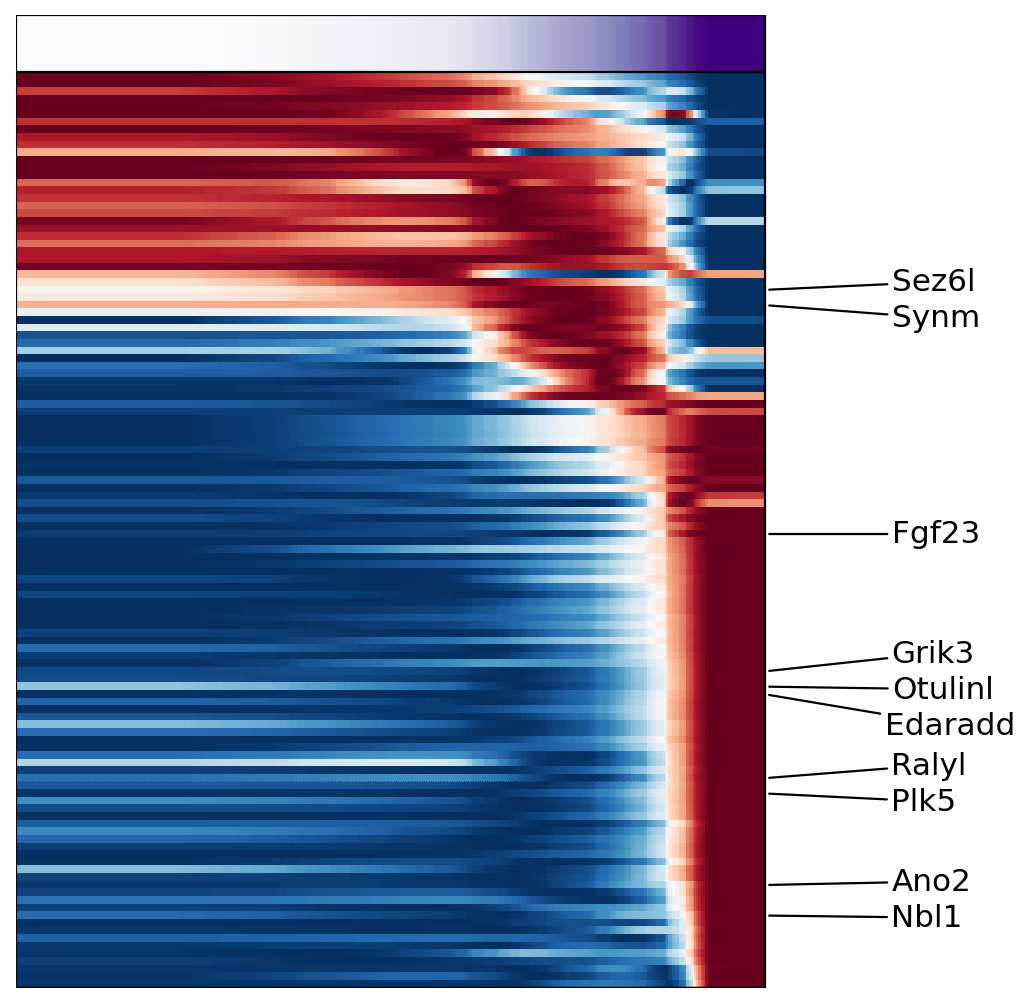

In [4]:
sc.set_figure_params(figsize=(5,5),dpi_save=600)
scf.pl.trends(adata_Ia[:,adata_Ia.var_names.isin(genes)],filter_complex=True,show_milsetones=False,
              pseudo_colormap="Reds",save="-Ia.png",save_genes="Ia_allgenes.tsv")
scf.pl.trends(adata_Ib[:,adata_Ib.var_names.isin(genes)],filter_complex=True,show_milsetones=False,
              pseudo_colormap="Blues",save="-Ib.png",save_genes="Ib_allgenes.tsv")
scf.pl.trends(adata_Ic[:,adata_Ic.var_names.isin(genes)],filter_complex=True,show_milsetones=False,
              pseudo_colormap="Greens",save="-Ic.png",save_genes="Ic_allgenes.tsv")
scf.pl.trends(adata_II[:,adata_II.var_names.isin(genes)],filter_complex=True,show_milsetones=False,
              pseudo_colormap="Purples",save="-II.png",save_genes="II_allgenes.tsv")

In [5]:
from scipy.stats import pearsonr
adata_Ia.var["corr"]=list(map(lambda g: pearsonr(adata_Ia.obs.t,adata_Ia[:,g].layers["fitted"].flatten())[0],adata_Ia.var_names))
adata_Ia.var["up"]=adata_Ia.var["corr"]>0
adata_Ib.var["corr"]=list(map(lambda g: pearsonr(adata_Ib.obs.t,adata_Ib[:,g].layers["fitted"].flatten())[0],adata_Ib.var_names))
adata_Ib.var["up"]=adata_Ib.var["corr"]>0
adata_Ic.var["corr"]=list(map(lambda g: pearsonr(adata_Ic.obs.t,adata_Ic[:,g].layers["fitted"].flatten())[0],adata_Ic.var_names))
adata_Ic.var["up"]=adata_Ic.var["corr"]>0
adata_II.var["corr"]=list(map(lambda g: pearsonr(adata_II.obs.t,adata_II[:,g].layers["fitted"].flatten())[0],adata_II.var_names))
adata_II.var["up"]=adata_II.var["corr"]>0

In [31]:
pd.Series(adata_Ia.var_names[adata_Ia.var["up"]]).to_csv("Ia_allup.tsv",header=False,index=False)
pd.Series(adata_Ib.var_names[adata_Ib.var["up"]]).to_csv("Ib_allup.tsv",header=False,index=False)
pd.Series(adata_Ic.var_names[adata_Ic.var["up"]]).to_csv("Ic_allup.tsv",header=False,index=False)
pd.Series(adata_II.var_names[adata_II.var["up"]]).to_csv("II_allup.tsv",header=False,index=False)

pd.Series(adata_Ia.var_names[~adata_Ia.var["up"]]).to_csv("Ia_alldown.tsv",header=False,index=False)
pd.Series(adata_Ib.var_names[~adata_Ib.var["up"]]).to_csv("Ib_alldown.tsv",header=False,index=False)
pd.Series(adata_Ic.var_names[~adata_Ic.var["up"]]).to_csv("Ic_alldown.tsv",header=False,index=False)
pd.Series(adata_II.var_names[~adata_II.var["up"]]).to_csv("II_alldown.tsv",header=False,index=False)